In [1]:
import warnings

import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

from utils import preprocess_data

warnings.filterwarnings("ignore")

In [3]:
X_train, X_test, y_train, y_test, train_df, test_df = preprocess_data(standardise=False)

In [4]:
def optimize_decision_tree(criterion, splitter, max_depth, min_samples_split, min_samples_leaf):
    """
    Optimize Decision Tree using Bayesian optimization
    """
    criterion_map = {0: 'gini', 1: 'entropy'} # Mapping numerical values to categorical values
    splitter_map = {0: 'best', 1: 'random'}
    model = DecisionTreeClassifier(
        criterion=criterion_map[int(criterion)],
        splitter=splitter_map[int(splitter)],
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42
    )
    return cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()


In [5]:
param_space = {
    'criterion': (0, 1),  # 0: 'gini', 1: 'entropy'
    'splitter': (0, 1),  # 0: 'best', 1: 'random'
    'max_depth': (1, 20),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20)
}

optimizer = BayesianOptimization(
    f=optimize_decision_tree,
    pbounds=param_space,
    random_state=42
)

# Start the optimization process
optimizer.maximize(init_points=5, n_iter=25)

|   iter    |  target   | criterion | max_depth | min_sa... | min_sa... | splitter  |
-------------------------------------------------------------------------------------
| 1         | 0.8004    | 0.3745    | 19.06     | 14.91     | 12.78     | 0.156     |
| 2         | 0.8228    | 0.156     | 2.104     | 17.46     | 12.82     | 0.7081    |
| 3         | 0.8024    | 0.02058   | 19.43     | 16.82     | 5.822     | 0.1818    |
| 4         | 0.8126    | 0.1834    | 6.781     | 10.97     | 9.775     | 0.2912    |
| 5         | 0.8105    | 0.6119    | 3.65      | 6.551     | 8.595     | 0.4561    |
| 6         | 0.8146    | 1.0       | 1.0       | 20.0      | 20.0      | 0.0       |
| 7         | 0.8146    | 0.0       | 1.0       | 20.0      | 5.604     | 1.0       |
| 8         | 0.8146    | 0.0       | 1.0       | 12.19     | 16.69     | 1.0       |
| 9         | 0.8146    | 0.0       | 6.141     | 20.0      | 13.41     | 1.0       |
| 10        | 0.8146    | 1.0       | 1.0       | 15.0

In [6]:
best_params = optimizer.max['params']
best_model = DecisionTreeClassifier(
    criterion=['gini', 'entropy'][int(best_params['criterion'])],
    splitter=['best', 'random'][int(best_params['splitter'])],
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    random_state=42
)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized Decision Tree Accuracy: {accuracy}")

Optimized Decision Tree Accuracy: 0.7886178861788617


Confusion Matrix:
[[23 20]
 [ 6 74]]


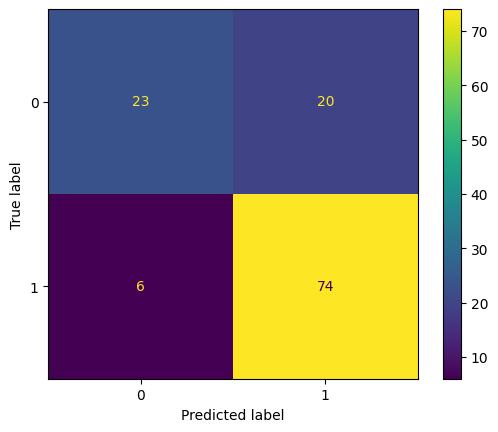

In [7]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot()
plt.show()

In [8]:
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.53      0.64        43
           1       0.79      0.93      0.85        80

    accuracy                           0.79       123
   macro avg       0.79      0.73      0.74       123
weighted avg       0.79      0.79      0.78       123



In [9]:
X_test_final = test_df.drop(columns=['Loan_ID'])
# Predict loan status using the trained Decision Tree model
y_test_pred = best_model.predict(X_test_final)
test_df['Loan_Status'] = ['Y' if pred == 1 else 'N' for pred in y_test_pred]
# Save the file
target_filename = "data/loan_sanction_test_with_predictions_decision_tree.csv"
test_df.to_csv(target_filename, index=False)
print(f"Predictions have been saved to {target_filename}.")

Predictions have been saved to data/loan_sanction_test_with_predictions_decision_tree.csv.
